In [31]:
# thêm thư viện
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from Naive_Bayes_Classifier import NaiveBayesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

In [4]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\MY
[nltk_data]     LAPTOP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MY LAPTOP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\MY
[nltk_data]     LAPTOP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# read data
df = pd.read_csv('5kEmails.csv')
df.columns = ['Label', 'Mail']

print(df.shape)
df.head()

(5171, 2)


,Label,Mail
0,0,Subject: enron methanol ; meter # : 988291\r\n...
1,0,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,1,"Subject: photoshop , windows , office . cheap ..."
4,0,Subject: re : indian springs\r\nthis deal is t...


In [6]:
# xóa bỏ mail trùng lặp
df.drop_duplicates(inplace=True)
print(df.shape)
df.head()

(4993, 2)


,Label,Mail
0,0,Subject: enron methanol ; meter # : 988291\r\n...
1,0,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,0,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,1,"Subject: photoshop , windows , office . cheap ..."
4,0,Subject: re : indian springs\r\nthis deal is t...


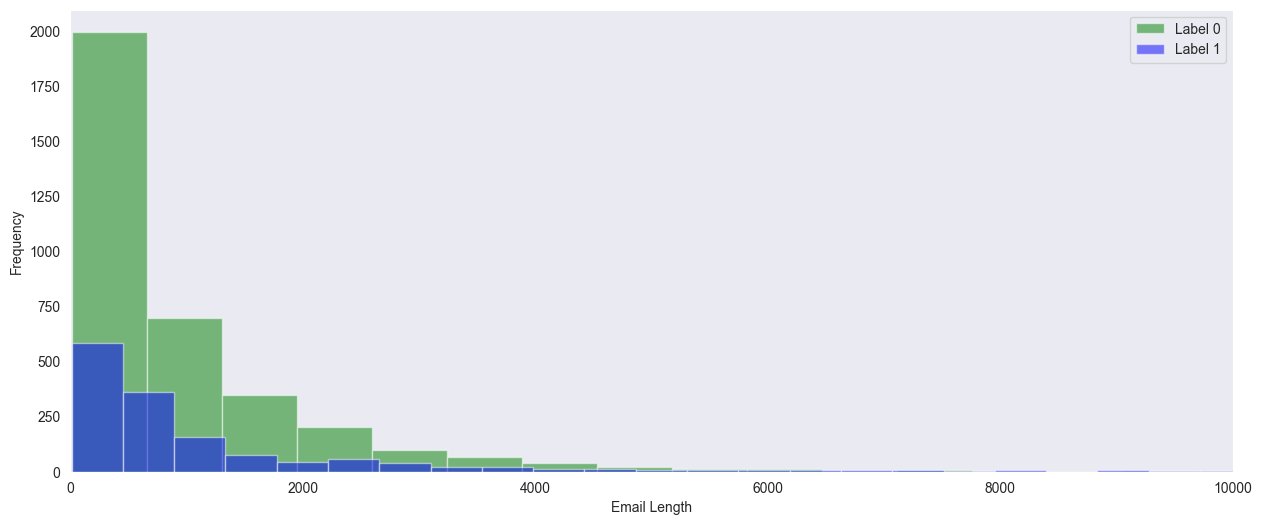

In [7]:
# thống kê độ dài email

df['Email Length'] = df['Mail'].apply(len)

plt.figure(figsize=(15, 6), facecolor='w')
plt.hist(df[df['Label'] == 0]['Email Length'], color='g', bins=50, alpha=0.5, label='Label 0')
plt.hist(df[df['Label'] == 1]['Email Length'], color='b', bins=50, alpha=0.5, label='Label 1')
plt.xlabel('Email Length')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0, 10000)
plt.grid(False)
plt.show()

Label
0    3531
1    1462
Name: count, dtype: int64


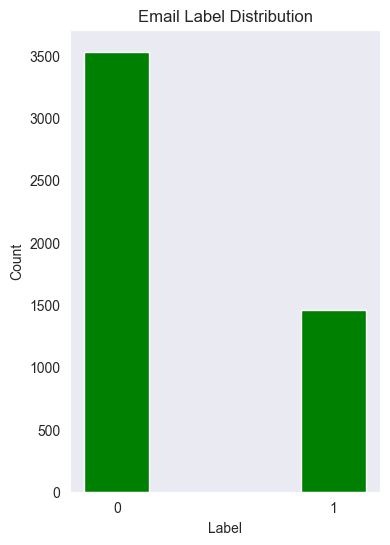

In [8]:
# thống kê số spam email & ham email
label_counts = df['Label'].value_counts()
print(label_counts)

plt.figure(figsize=(4, 6), facecolor='w')
plt.bar(label_counts.index, label_counts.values, color='g', align='center', width=0.3)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Email Label Distribution')
plt.xticks(label_counts.index)
plt.grid(False)
plt.show()


In [9]:
# tách thành 2 tập train và test
randomized = df.sample(frac=1, random_state=1)
train_size = round(len(randomized)*0.8)
train = randomized[:train_size].reset_index(drop=True)
test = randomized[train_size:].reset_index(drop=True)
print('Train set size ',train.shape)
print('Test set size', test.shape)

Train set size  (3994, 3)
Test set size (999, 3)


In [10]:
# tiền xử lý dữ liệu (xóa các đường dẫn, xóa dấu câu, xóa các stopword, đưa về dạng chuẩn của từ)
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def process_text(text):
    text = text.lower()
    #  Loại bỏ các đường dẫn HTTP hoặc HTTPS khỏi văn bản
    text = re.sub(r'http\S+', '', text)
    no_punc = [char for char in text if char not in string.punctuation]
    no_punc = ''.join(no_punc)
    # loại bỏ các từ không cần thiết (stopwords) trong tiếng Anh
    text = [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]
    text = ' '.join(text)
    # Loại bỏ dấu cách sau ký tự "’" khỏi văn bản.
    text = text.replace('’ ', '')
    text = text.split()
    return text

print(process_text("Subject: photoshop , windows , office . cheap . main trending abasements darer prudently fortuitous undergone lighthearted charm orinoco taster railroad affluent pornographic cuvier irvin parkhouse blameworthy chlorophyll robed diagrammatic fogarty clears bayda inconveniencing managing represented smartness hashish academies shareholders unload badness danielson pure caffein spaniard chargeable levin"))


['subject', 'photoshop', 'window', 'office', 'cheap', 'main', 'trend', 'abasement', 'darer', 'prudently', 'fortuitous', 'undergone', 'lighthearted', 'charm', 'orinoco', 'taster', 'railroad', 'affluent', 'pornographic', 'cuvier', 'irvin', 'parkhouse', 'blameworthy', 'chlorophyll', 'robed', 'diagrammatic', 'fogarty', 'clear', 'bayda', 'inconvenience', 'manage', 'represent', 'smartness', 'hashish', 'academy', 'shareholder', 'unload', 'badness', 'danielson', 'pure', 'caffein', 'spaniard', 'chargeable', 'levin']


In [11]:
bag_word = []
test_mails = test['Mail']
test_labels = test['Label']
test_mails2 = []
train_mails = train['Mail']
train_labels = train['Label']
train_mails2 = []

test_mails = test_mails.apply(process_text)
train_mails = train_mails.apply(process_text)

40852


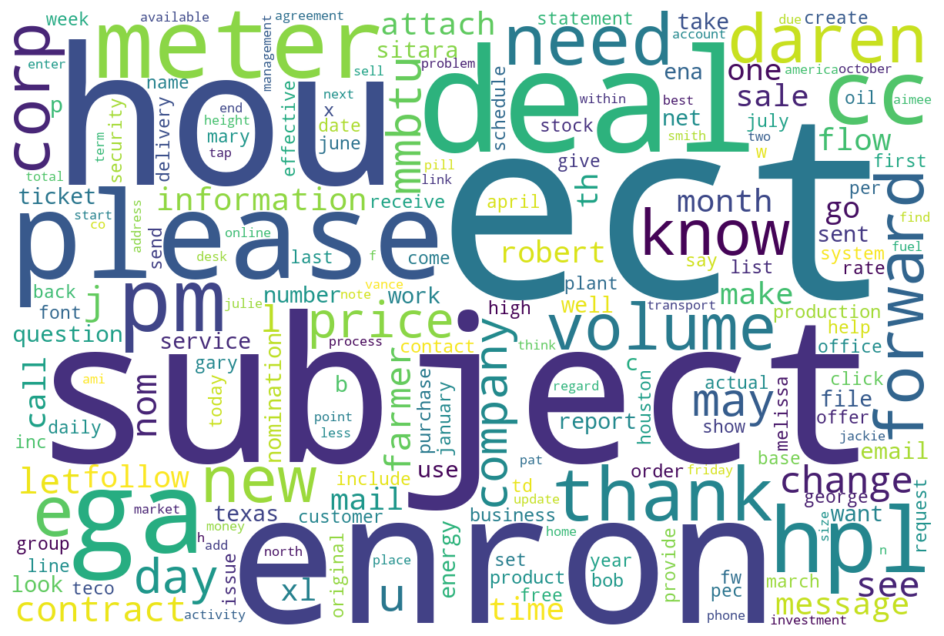

In [12]:
# In bag of word tập train
text = ""

for message in train_mails:
    text = text + " ".join(message) + " "
text1 = text.split()
text1 = set(text1)
print(len(text1))

wordcloud = WordCloud(width=1200, height=800, collocations=False, background_color='white').generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

18322


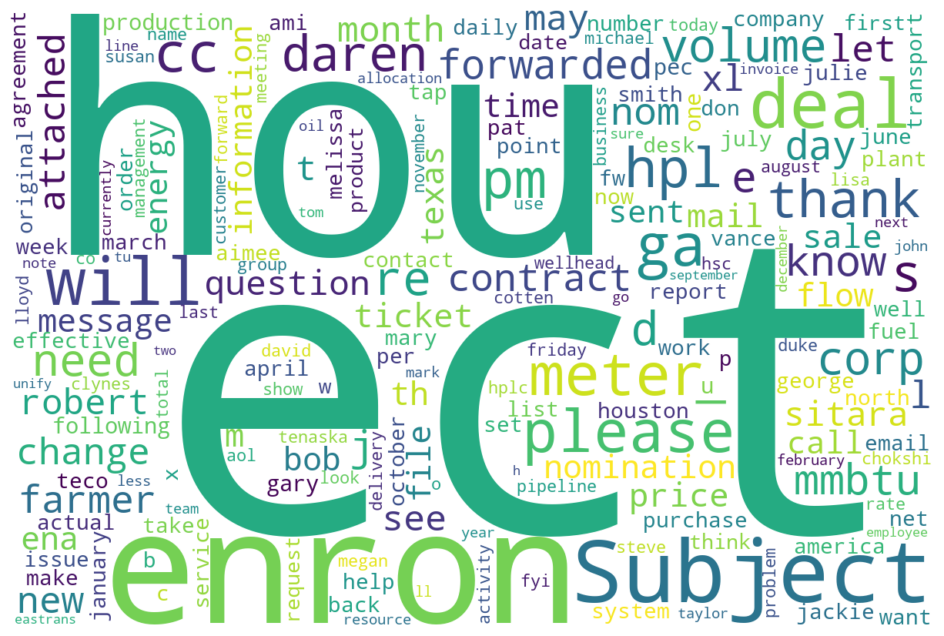

In [13]:
# In bag of word tập train (ham email)
text = ""

for message in train[train.Label == 0].Mail:
    words = message.split()
    text = text + " ".join(words) + " "

text1 = text.split()
text1 = set(text1)
print((len(text1)))

wordcloud = WordCloud(width=1200, height=800, collocations=False, background_color='white').generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

34157


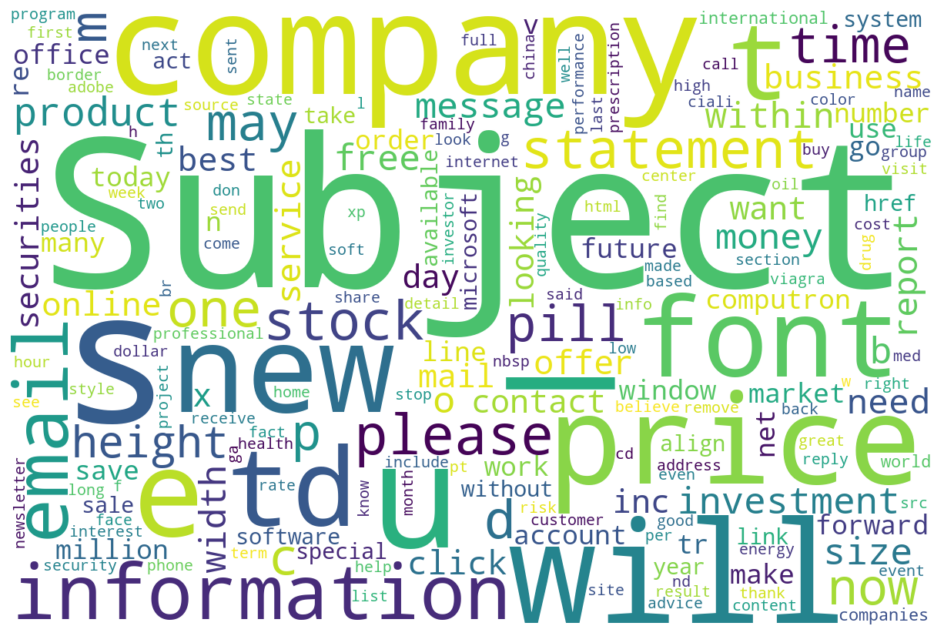

In [14]:
# In bag of word tập train (spam email)
text = ""

for message in train[train.Label == 1].Mail:
    words = message.split()
    text = text + " ".join(words) + " "

text1 = text.split()
text1 = set(text1)
print(len(text1))

wordcloud = WordCloud(width=1200, height=800, collocations=False, background_color='white').generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
# vecto tập train và test sau xử lý

bag_word = []
for i in train_mails:
    words = i
    bag_word += words

bag_word = set(bag_word)
bag_word = list(bag_word)

def to_vector(mail):
    split_mail = mail
    m_vec = np.zeros(len(bag_word))
    count = Counter(split_mail)
    for i, word in enumerate(bag_word):
        m_vec[i] += count[word]
    return m_vec

for i, mail in enumerate(test_mails):
    test_mails2.append(to_vector(mail))

for i, mail in enumerate(train_mails):
    train_mails2.append(to_vector(mail))

d = {'Mail': train_mails2,
     'Label': train_labels}
Train_data = pd.DataFrame(data=d)

d = {'Mail': test_mails2,
     'Label': test_labels}
Test_data = pd.DataFrame(data=d)


In [33]:
# Sử dụng mô hình Naive-Bayes
model = NaiveBayesClassifier()
model.fit(Train_data['Mail'], Train_data['Label'])
result = model.predict(Test_data)
model.score(Test_data)



AttributeError: 'NaiveBayesClassifier' object has no attribute 'NaiveBayescalculate'

In [28]:
# Sử dụng mô hình Naive-Bayes(thư viện)
train_mails = list(Train_data['Mail'])
train_labels = list(Train_data['Label'])
test_mails = list(Test_data['Mail'])
test_labels = list(Test_data['Label'])

model1 = MultinomialNB()
model1.fit(train_mails, train_labels)
result1= model1.predict(test_mails)
model1.score(test_mails, test_labels)

0.978978978978979

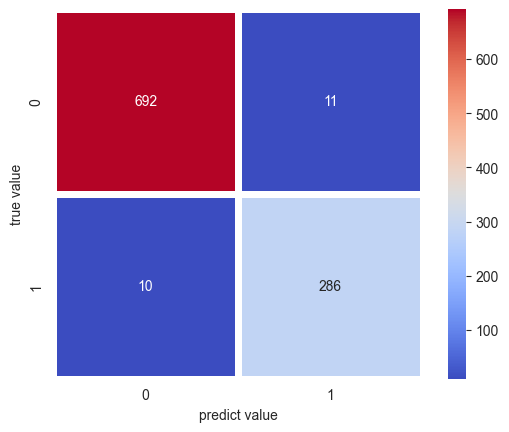

In [29]:
mat = confusion_matrix(test_labels, result1)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='coolwarm', linewidths=5)
plt.xlabel('predict value')
plt.ylabel('true value')
plt.show()